In [265]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [266]:
import h5py

In [267]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [268]:
from uatu.scattering import *
from kymatio import Scattering2D

In [269]:
from scipy import fftpack
from scipy.ndimage import gaussian_filter
import numpy as np
import pylab as py
#import radialProfile
from scipy.fftpack import fft2

In [270]:
model_path = '/home/sean/Git/uatu/networks/resnet_max_mode_0_J_0_epoch_05_adv.pth'

In [271]:
#mode = 2
mode = 0
#max_order = 2
max_order = 0

#J = 2
J = 0
L = 8
K = int(1 + L*J +(L**2)*(J*(J-1))/2.0)

width = 2
smooth = 0
shape = (256, 256)

In [272]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

In [273]:
scattering = lambda x: x
#scattering = lambda x: gaussian_filter(x, 1)

In [274]:
model = Scattering2dResNet(K, J, k=width).to(device)

In [275]:
model.load_state_dict(torch.load(model_path, map_location='cpu'))

<All keys matched successfully>

In [276]:
model.eval()

Scattering2dResNet(
  (init_conv): Sequential(
    (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
  )
  (layer_0): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [277]:
def log_barrier(x_p, x_o, eps=2., lam=1e6):
    # TODO, in pytorch
    norm = (x_p - x_o).norm(p=float('Inf')) + 1e-6

    assert norm < eps
    return -torch.log(eps - norm )/lam

In [278]:
def get_embedding(x, model):
    x = scattering(x)

    x = x.view(1, model.K, model.input_size, model.input_size)#

############# UNCOMMENT ME ################
    x = model.init_conv(x)
    
    for i,l in enumerate(model.layers):
        #if i ==1:
        #    break
        x = l(x)
    return model.avgpool(x)

In [279]:
def fgsm_attack(image, eps, data_grad):
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image - eps*sign_data_grad
    #perturbed_image = image - eps*data_grad/(data_grad.sum()/(256))

    # Adding clipping to maintain [0,1] range
    #perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [280]:
def azimuthalAverage(image, center=None):
    """
    Calculate the azimuthally averaged radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)

    if not center:
        center = np.array([(x.max()-x.min())/2.0, (x.max()-x.min())/2.0])

    r = np.hypot(x - center[0], y - center[1])

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    #print(deltar.shape)
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr

    return radial_prof

In [281]:
def image_ps(image):
    l = np.linspace(128, 128**2, 180)
    cmap = ConvergenceMap(image, angle=4*deg)
    _, psd1D = cmap.powerSpectrum(l)
    '''
    # Take the fourier transform of the image.
    F1 = fftpack.fft2(image)

    # Now shift the quadrants around so that low spatial frequencies are in
    # the center of the 2D fourier transformed image.
    F2 = fftpack.fftshift( F1 )

    # Calculate a 2D power spectrum
    psd2D = np.abs( F2 )**2

    # Calculate the azimuthally averaged 1D power spectrum
    psd1D = azimuthalAverage(psd2D)
    '''
    return psd1D#/psd1D[0]

In [282]:
def plot_ps(X_orig, X_target, X_attack):
    
    X_orig = X_orig.data.to('cpu').numpy()
    X_target = X_target.data.to('cpu').numpy()
    X_attack = X_attack.data.to('cpu').numpy()

    attacked_ps = image_ps(X_attack.squeeze())
    target_ps = image_ps(X_target.squeeze())
    normal_ps = image_ps(X_orig.squeeze())
    diff_ps = image_ps((X_attack.squeeze()- X.squeeze()).squeeze())
    
    #fig = plt.figure(figsize = (8, 12))
    #plt.subplot(211)
    plt.plot(attacked_ps, label = 'Attacked' )
    plt.plot(target_ps, label = 'Target')
    plt.plot(normal_ps, label = 'Original')
    #plt.plot(diff_ps, label = 'Diff')

    plt.legend(loc='best')
    plt.loglog();
    #plt.subplot(212)
    #plt.title("Attacked/Normal")
    #plt.plot(attacked_ps/normal_ps, label = 'Attacked')
    #plt.plot(target_ps/normal_ps, label = 'Target')
    #plt.legend(loc='best')
    #plt.ylim([0.4, 6])
    #plt.loglog();
    plt.show();

In [283]:
def compute_robust_map(model, x0, xt): #use_log_barrier = True, log_eps = 1.5)

    # Send the data and label to the device
    x0, xt = x0.to(device), xt.to(device)
    # Set requires_grad attribute of tensor. Important for Attack
    perturbed_x0 = x0.clone()

    perturbed_x0.requires_grad = True
    scattering.requires_grad = False
    # Forward pass the data through the model
    init_pred = get_embedding(xt, model)
    #init_fft = 2*torch.log(torch.abs(torch.rfft(xt.squeeze(), 2)))
    # Calculate the 6oss
    epsilon =1e-3

    for i in range(500):
        output = get_embedding(perturbed_x0, model)
        # TODO put power spectrum here too? 
        loss = (output-init_pred).norm() + log_barrier(perturbed_x0, x0) #+ (init_fft - torch.log(torch.abs(torch.rfft(perturbed_x0.squeeze(), 2)))).norm() #- log_barrier(perturbed_x0, xt)
        #print( (output-init_pred).norm(), log_barrier(perturbed_x0, xt))
        print(loss)
        # Zero all existing gradients
        model.zero_grad()
        # Calculate gradients of model in backward pass
        loss.backward(retain_graph = True)

        # Collect datagrad

        x0_grad = perturbed_x0.grad.data
        # Call FGSM Attack
        if i%100 == 0:
            print('*'*20, i, '*'*20)
            epsilon= epsilon*0.9
            print('e', epsilon)
            plot_ps(x0, xt, perturbed_x0)
            plt.imshow(perturbed_x0.data.to('cpu').numpy().squeeze())
            plt.show();
            
        perturbed_x0 = fgsm_attack(perturbed_x0, epsilon, x0_grad)
        
        perturbed_x0 = torch.autograd.Variable(perturbed_x0.data, requires_grad=True)

    return perturbed_x0, init_pred, output

In [284]:
def count_peaks(im, size = 1):
    # i don't know if there's a faster way to do this but alas
    peak_idxs = np.zeros_like(im, dtype = bool)
    for i in range(size, im.shape[0]-size):
        for j in range(size, im.shape[1]-size): # no peaks on the boundaries i declare
            block = im[i-size:i+size+1, j-size:j+size+1].flatten()
            if np.all(im[i,j] >= block):
                peak_idxs[i,j] = True
    return im[peak_idxs]

In [285]:
with h5py.File('../data/UatuLightconeTraining.hdf5', 'r') as f:
    mean, std =  f.attrs['mean'], f.attrs['std']

In [286]:
from uatu.watchers.Dataset import *
transform = lambda x : torch.Tensor(gaussian_filter(x, smooth))
#transform = torch.Tensor

train_dset = DatasetFromFile('../data/UatuLightconeTest.hdf5',1, shuffle=True, augment=False, train_test_split = 0.8,\
                                 whiten = True, cache_size = 100, transform=transform)
test_dset = train_dset.get_test_dset() 

In [287]:
preds = []
truths = []
for batch_idx, (X, Y) in enumerate(test_dset):
    #print(batch_idx,)
    preds.append(model(scattering(X.to('cuda'))).to('cpu').detach().numpy().squeeze())
    truths.append(Y)
    print(preds[-1], Y)

[0.30982438 0.87314016] tensor([[0.3123, 0.9069]])
[0.32263935 0.8997257 ] tensor([[0.3123, 0.9069]])
[0.31272238 0.8837613 ] tensor([[0.3123, 0.9069]])
[0.30703443 0.8702348 ] tensor([[0.3123, 0.9069]])
[0.30223998 0.8563717 ] tensor([[0.3123, 0.9069]])
[0.311826  0.8823718] tensor([[0.3123, 0.9069]])
[0.32602453 0.906306  ] tensor([[0.3123, 0.9069]])
[0.31986135 0.8913524 ] tensor([[0.3123, 0.9069]])
[0.31660184 0.8934886 ] tensor([[0.3123, 0.9069]])
[0.31373686 0.8742233 ] tensor([[0.3123, 0.9069]])
[0.3233319  0.89861476] tensor([[0.3123, 0.9069]])
[0.33117613 0.92080474] tensor([[0.3123, 0.9069]])
[0.32442006 0.9089954 ] tensor([[0.3123, 0.9069]])
[0.31671783 0.8932467 ] tensor([[0.3123, 0.9069]])
[0.31696716 0.8812606 ] tensor([[0.3123, 0.9069]])
[0.3195314 0.895469 ] tensor([[0.3123, 0.9069]])
[0.32478034 0.9029332 ] tensor([[0.3123, 0.9069]])
[0.31238568 0.86899686] tensor([[0.3123, 0.9069]])
[0.31039125 0.8731467 ] tensor([[0.3123, 0.9069]])
[0.31006828 0.8741435 ] tensor([[0.

[0.32705018 0.91350543] tensor([[0.3123, 0.9069]])
[0.32646453 0.9062609 ] tensor([[0.3123, 0.9069]])
[0.32889086 0.9182769 ] tensor([[0.3123, 0.9069]])
[0.32019207 0.9017462 ] tensor([[0.3123, 0.9069]])
[0.33163068 0.9211071 ] tensor([[0.3123, 0.9069]])
[0.32819703 0.91734594] tensor([[0.3123, 0.9069]])
[0.32064947 0.89905405] tensor([[0.3123, 0.9069]])
[0.3085848 0.8738481] tensor([[0.3123, 0.9069]])
[0.3057414 0.8673174] tensor([[0.3123, 0.9069]])
[0.3103297 0.8780381] tensor([[0.3123, 0.9069]])
[0.30565897 0.86609626] tensor([[0.3123, 0.9069]])
[0.3047104 0.8614299] tensor([[0.3123, 0.9069]])
[0.31576404 0.886807  ] tensor([[0.3123, 0.9069]])
[0.3251727 0.9147334] tensor([[0.3123, 0.9069]])
[0.31978366 0.89230853] tensor([[0.3123, 0.9069]])
[0.3102962  0.88024926] tensor([[0.3123, 0.9069]])
[0.3120363  0.88071686] tensor([[0.3123, 0.9069]])
[0.32033446 0.89320177] tensor([[0.3123, 0.9069]])
[0.31810308 0.891735  ] tensor([[0.3123, 0.9069]])
[0.3249487  0.90484285] tensor([[0.3123, 

[0.24553607 0.74220985] tensor([[0.2561, 0.7546]])
[0.26763958 0.7863223 ] tensor([[0.2561, 0.7546]])
[0.268281  0.7875174] tensor([[0.2561, 0.7546]])
[0.2589054 0.7682706] tensor([[0.2561, 0.7546]])
[0.25462508 0.7640221 ] tensor([[0.2561, 0.7546]])
[0.24796918 0.74942446] tensor([[0.2561, 0.7546]])
[0.25149146 0.75634915] tensor([[0.2561, 0.7546]])
[0.24601549 0.74247503] tensor([[0.2561, 0.7546]])
[0.24432077 0.7383657 ] tensor([[0.2561, 0.7546]])
[0.24035427 0.72879905] tensor([[0.2561, 0.7546]])
[0.26107338 0.77067053] tensor([[0.2561, 0.7546]])
[0.27085155 0.79436076] tensor([[0.2561, 0.7546]])
[0.26609534 0.7862031 ] tensor([[0.2561, 0.7546]])
[0.25838524 0.76958823] tensor([[0.2561, 0.7546]])
[0.26116356 0.77005684] tensor([[0.2561, 0.7546]])
[0.26333836 0.7842726 ] tensor([[0.2561, 0.7546]])
[0.26529977 0.7814345 ] tensor([[0.2561, 0.7546]])
[0.25379717 0.7636627 ] tensor([[0.2561, 0.7546]])
[0.27545935 0.7978611 ] tensor([[0.2561, 0.7546]])
[0.2941533 0.8407558] tensor([[0.25

[0.26426172 0.7827094 ] tensor([[0.2561, 0.7546]])
[0.24266532 0.735646  ] tensor([[0.2561, 0.7546]])
[0.24881984 0.75292057] tensor([[0.2561, 0.7546]])
[0.24134229 0.73191065] tensor([[0.2561, 0.7546]])
[0.23770387 0.7267953 ] tensor([[0.2561, 0.7546]])
[0.2534428  0.75681937] tensor([[0.2561, 0.7546]])
[0.256351   0.76270014] tensor([[0.2561, 0.7546]])
[0.25701395 0.76438516] tensor([[0.2561, 0.7546]])
[0.2550236 0.7626758] tensor([[0.2561, 0.7546]])
[0.26314917 0.7778399 ] tensor([[0.2561, 0.7546]])
[0.2523752  0.76076275] tensor([[0.2561, 0.7546]])
[0.25781137 0.7642629 ] tensor([[0.2561, 0.7546]])
[0.26891878 0.78991073] tensor([[0.2561, 0.7546]])
[0.25279588 0.7589073 ] tensor([[0.2561, 0.7546]])
[0.25563335 0.7611966 ] tensor([[0.2561, 0.7546]])
[0.25631368 0.76622313] tensor([[0.2561, 0.7546]])
[0.25167868 0.7569551 ] tensor([[0.2561, 0.7546]])
[0.25710687 0.7659852 ] tensor([[0.2561, 0.7546]])
[0.25022703 0.74995184] tensor([[0.2561, 0.7546]])
[0.25776908 0.7723805 ] tensor([[

[0.33608487 0.9309879 ] tensor([[0.3421, 0.9549]])
[0.33443633 0.9304876 ] tensor([[0.3421, 0.9549]])
[0.3378709 0.9322687] tensor([[0.3421, 0.9549]])
[0.33432633 0.9253663 ] tensor([[0.3421, 0.9549]])
[0.3383536 0.9349922] tensor([[0.3421, 0.9549]])
[0.3400071 0.9458087] tensor([[0.3421, 0.9549]])
[0.33512604 0.9254124 ] tensor([[0.3421, 0.9549]])
[0.33917242 0.9355246 ] tensor([[0.3421, 0.9549]])
[0.34658238 0.95168656] tensor([[0.3421, 0.9549]])
[0.32710952 0.91132456] tensor([[0.3421, 0.9549]])
[0.3341659 0.9233866] tensor([[0.3421, 0.9549]])
[0.32026485 0.8998369 ] tensor([[0.3421, 0.9549]])
[0.3228021 0.9026529] tensor([[0.3421, 0.9549]])
[0.34177428 0.9413123 ] tensor([[0.3421, 0.9549]])
[0.352952  0.9622464] tensor([[0.3421, 0.9549]])
[0.34806877 0.9516367 ] tensor([[0.3421, 0.9549]])
[0.35035205 0.95662445] tensor([[0.3421, 0.9549]])
[0.33351094 0.9294818 ] tensor([[0.3421, 0.9549]])
[0.33813435 0.93191   ] tensor([[0.3421, 0.9549]])
[0.341943  0.9378697] tensor([[0.3421, 0.95

[0.3484249  0.95823723] tensor([[0.3421, 0.9549]])
[0.34650058 0.95528275] tensor([[0.3421, 0.9549]])
[0.3421785  0.94834846] tensor([[0.3421, 0.9549]])
[0.33723158 0.9284615 ] tensor([[0.3421, 0.9549]])
[0.34648046 0.9516755 ] tensor([[0.3421, 0.9549]])
[0.3483749  0.95912814] tensor([[0.3421, 0.9549]])
[0.34301648 0.9521927 ] tensor([[0.3421, 0.9549]])
[0.3478911 0.9557848] tensor([[0.3421, 0.9549]])
[0.34242773 0.94808394] tensor([[0.3421, 0.9549]])
[0.333059  0.9227798] tensor([[0.3421, 0.9549]])
[0.33913472 0.93932223] tensor([[0.3421, 0.9549]])
[0.35175526 0.9555955 ] tensor([[0.3421, 0.9549]])
[0.3671468 0.9925391] tensor([[0.3421, 0.9549]])
[0.31676003 0.88955325] tensor([[0.3421, 0.9549]])
[0.32505098 0.9074211 ] tensor([[0.3421, 0.9549]])
[0.32569903 0.9157253 ] tensor([[0.3421, 0.9549]])
[0.33178723 0.92940366] tensor([[0.3421, 0.9549]])
[0.330467  0.9172188] tensor([[0.3421, 0.9549]])
[0.3416739 0.9427185] tensor([[0.3421, 0.9549]])
[0.3380672 0.9291987] tensor([[0.3421, 0.

[0.33178115 0.92452973] tensor([[0.3457, 0.9596]])
[0.34382534 0.9472698 ] tensor([[0.3457, 0.9596]])
[0.34568757 0.9492747 ] tensor([[0.3457, 0.9596]])
[0.33216414 0.91981184] tensor([[0.3457, 0.9596]])
[0.3363147  0.92978865] tensor([[0.3457, 0.9596]])
[0.34110796 0.9376917 ] tensor([[0.3457, 0.9596]])
[0.3510276 0.9577181] tensor([[0.3457, 0.9596]])
[0.345432   0.94484603] tensor([[0.3457, 0.9596]])
[0.3407701 0.9434876] tensor([[0.3457, 0.9596]])
[0.34076205 0.9374369 ] tensor([[0.3457, 0.9596]])
[0.34443283 0.9520936 ] tensor([[0.3457, 0.9596]])
[0.34392244 0.94924885] tensor([[0.3457, 0.9596]])
[0.33749565 0.93493474] tensor([[0.3457, 0.9596]])
[0.34979028 0.9486195 ] tensor([[0.3457, 0.9596]])
[0.35428584 0.9623662 ] tensor([[0.3457, 0.9596]])
[0.35785872 0.9708734 ] tensor([[0.3457, 0.9596]])
[0.35623813 0.9680972 ] tensor([[0.3457, 0.9596]])
[0.36334267 0.98199207] tensor([[0.3457, 0.9596]])
[0.36549965 0.97554016] tensor([[0.3457, 0.9596]])
[0.3674087 0.9929979] tensor([[0.34

[0.36075556 0.97900677] tensor([[0.3457, 0.9596]])
[0.35594466 0.96252215] tensor([[0.3457, 0.9596]])
[0.33730227 0.9315477 ] tensor([[0.3457, 0.9596]])
[0.34794295 0.9472941 ] tensor([[0.3457, 0.9596]])
[0.35114866 0.9573325 ] tensor([[0.3457, 0.9596]])
[0.34755918 0.9664037 ] tensor([[0.3457, 0.9596]])
[0.30114973 0.8539221 ] tensor([[0.2931, 0.8585]])
[0.30339903 0.860951  ] tensor([[0.2931, 0.8585]])
[0.2949018 0.8408014] tensor([[0.2931, 0.8585]])
[0.30384043 0.8600464 ] tensor([[0.2931, 0.8585]])
[0.30916378 0.8761913 ] tensor([[0.2931, 0.8585]])
[0.31295526 0.8828717 ] tensor([[0.2931, 0.8585]])
[0.31121588 0.8765961 ] tensor([[0.2931, 0.8585]])
[0.30124363 0.85945153] tensor([[0.2931, 0.8585]])
[0.30301812 0.85304666] tensor([[0.2931, 0.8585]])
[0.2906897 0.8366309] tensor([[0.2931, 0.8585]])
[0.2875155 0.8242768] tensor([[0.2931, 0.8585]])
[0.30241027 0.86237264] tensor([[0.2931, 0.8585]])
[0.29584834 0.8459414 ] tensor([[0.2931, 0.8585]])
[0.2996357 0.8555611] tensor([[0.2931

[0.30497482 0.8647911 ] tensor([[0.2931, 0.8585]])
[0.31026733 0.8823816 ] tensor([[0.2931, 0.8585]])
[0.30707628 0.8741236 ] tensor([[0.2931, 0.8585]])
[0.30967698 0.8717948 ] tensor([[0.2931, 0.8585]])
[0.3073519 0.8772417] tensor([[0.2931, 0.8585]])
[0.3169559 0.8842541] tensor([[0.2931, 0.8585]])
[0.31636506 0.88522756] tensor([[0.2931, 0.8585]])
[0.3178079 0.8871188] tensor([[0.2931, 0.8585]])
[0.3075613 0.8719394] tensor([[0.2931, 0.8585]])
[0.29543987 0.8446365 ] tensor([[0.2931, 0.8585]])
[0.29252324 0.8411991 ] tensor([[0.2931, 0.8585]])
[0.3005578  0.85089505] tensor([[0.2931, 0.8585]])
[0.27844357 0.81234103] tensor([[0.2931, 0.8585]])
[0.28823674 0.8324035 ] tensor([[0.2931, 0.8585]])
[0.2878825  0.83135414] tensor([[0.2931, 0.8585]])
[0.29035577 0.8311913 ] tensor([[0.2931, 0.8585]])
[0.2973953 0.8502291] tensor([[0.2931, 0.8585]])
[0.30325294 0.8658639 ] tensor([[0.2931, 0.8585]])
[0.29916686 0.8597482 ] tensor([[0.2931, 0.8585]])
[0.30676776 0.87880945] tensor([[0.2931, 

[0.32259414 0.90419954] tensor([[0.3191, 0.9099]])
[0.3258361 0.9096608] tensor([[0.3191, 0.9099]])
[0.31990954 0.8959408 ] tensor([[0.3191, 0.9099]])
[0.30578738 0.86662734] tensor([[0.3191, 0.9099]])
[0.3132702 0.8746871] tensor([[0.3191, 0.9099]])
[0.31687948 0.8885145 ] tensor([[0.3191, 0.9099]])
[0.30734622 0.87565655] tensor([[0.3191, 0.9099]])
[0.31578144 0.88416183] tensor([[0.3191, 0.9099]])
[0.32833982 0.9124318 ] tensor([[0.3191, 0.9099]])
[0.317027   0.89205414] tensor([[0.3191, 0.9099]])
[0.33053586 0.9130414 ] tensor([[0.3191, 0.9099]])
[0.3347824 0.9216395] tensor([[0.3191, 0.9099]])
[0.32976827 0.9100912 ] tensor([[0.3191, 0.9099]])
[0.32086504 0.89415145] tensor([[0.3191, 0.9099]])
[0.31131303 0.8850743 ] tensor([[0.3191, 0.9099]])
[0.31924877 0.89030844] tensor([[0.3191, 0.9099]])
[0.31653216 0.88182616] tensor([[0.3191, 0.9099]])
[0.31993625 0.89630044] tensor([[0.3191, 0.9099]])
[0.31479198 0.88472456] tensor([[0.3191, 0.9099]])
[0.31172878 0.87499374] tensor([[0.31

[0.33623272 0.9246055 ] tensor([[0.3191, 0.9099]])
[0.32089686 0.904504  ] tensor([[0.3191, 0.9099]])
[0.32162824 0.9063082 ] tensor([[0.3191, 0.9099]])
[0.3203079 0.9035374] tensor([[0.3191, 0.9099]])
[0.3182902 0.8914005] tensor([[0.3191, 0.9099]])
[0.31110197 0.87421644] tensor([[0.3191, 0.9099]])
[0.3225535  0.89615315] tensor([[0.3191, 0.9099]])
[0.34981412 0.95442647] tensor([[0.3191, 0.9099]])
[0.3457386  0.94546914] tensor([[0.3191, 0.9099]])
[0.33278924 0.9169016 ] tensor([[0.3191, 0.9099]])
[0.3442125  0.94176817] tensor([[0.3191, 0.9099]])
[0.3449333  0.93776125] tensor([[0.3191, 0.9099]])
[0.3469018  0.94940585] tensor([[0.3191, 0.9099]])
[0.34438482 0.94709074] tensor([[0.3191, 0.9099]])
[0.34270588 0.9490791 ] tensor([[0.3191, 0.9099]])
[0.33726138 0.92570573] tensor([[0.3191, 0.9099]])
[0.3414729 0.9393106] tensor([[0.3191, 0.9099]])
[0.33998567 0.9355457 ] tensor([[0.3191, 0.9099]])
[0.32727104 0.919889  ] tensor([[0.3191, 0.9099]])
[0.32264644 0.9091487 ] tensor([[0.31

[0.25972256 0.7740501 ] tensor([[0.2644, 0.7980]])
[0.25207224 0.7577621 ] tensor([[0.2644, 0.7980]])
[0.25567394 0.76344955] tensor([[0.2644, 0.7980]])
[0.27383468 0.79738134] tensor([[0.2644, 0.7980]])
[0.27741852 0.80697227] tensor([[0.2644, 0.7980]])
[0.27383786 0.8001431 ] tensor([[0.2644, 0.7980]])
[0.27956894 0.81271064] tensor([[0.2644, 0.7980]])
[0.27287808 0.80078244] tensor([[0.2644, 0.7980]])
[0.27079675 0.79343414] tensor([[0.2644, 0.7980]])
[0.26580736 0.7871051 ] tensor([[0.2644, 0.7980]])
[0.2565074  0.76264113] tensor([[0.2644, 0.7980]])
[0.27210805 0.7923083 ] tensor([[0.2644, 0.7980]])
[0.26096466 0.7743367 ] tensor([[0.2644, 0.7980]])
[0.25332743 0.75927895] tensor([[0.2644, 0.7980]])
[0.26199543 0.7747892 ] tensor([[0.2644, 0.7980]])
[0.2689233 0.7895687] tensor([[0.2644, 0.7980]])
[0.26898703 0.79096276] tensor([[0.2644, 0.7980]])
[0.2667128 0.7862951] tensor([[0.2644, 0.7980]])
[0.27090007 0.79708755] tensor([[0.2644, 0.7980]])
[0.2599206  0.77055526] tensor([[0.

[0.2708874  0.79950017] tensor([[0.2644, 0.7980]])
[0.27131993 0.79434264] tensor([[0.2644, 0.7980]])
[0.28585118 0.82016057] tensor([[0.2644, 0.7980]])
[0.3010848  0.85570794] tensor([[0.2644, 0.7980]])
[0.28268123 0.81662315] tensor([[0.2644, 0.7980]])
[0.27723137 0.8096183 ] tensor([[0.2644, 0.7980]])
[0.273625  0.8042742] tensor([[0.2644, 0.7980]])
[0.27700046 0.8077718 ] tensor([[0.2644, 0.7980]])
[0.27436543 0.79771364] tensor([[0.2644, 0.7980]])
[0.27868393 0.810495  ] tensor([[0.2644, 0.7980]])
[0.27399936 0.8039631 ] tensor([[0.2644, 0.7980]])
[0.27098945 0.7966488 ] tensor([[0.2644, 0.7980]])
[0.280077   0.80973136] tensor([[0.2644, 0.7980]])
[0.27141497 0.79550135] tensor([[0.2644, 0.7980]])
[0.26872766 0.79130775] tensor([[0.2644, 0.7980]])
[0.26321834 0.78131   ] tensor([[0.2644, 0.7980]])
[0.2570562  0.76407814] tensor([[0.2644, 0.7980]])
[0.26036176 0.77281487] tensor([[0.2644, 0.7980]])
[0.27559254 0.80569077] tensor([[0.2644, 0.7980]])
[0.29129207 0.8315352 ] tensor([[

[0.35431007 0.96312064] tensor([[0.3461, 0.9635]])
[0.35587302 0.96872485] tensor([[0.3461, 0.9635]])
[0.35416842 0.97207946] tensor([[0.3461, 0.9635]])
[0.35965332 0.966516  ] tensor([[0.3461, 0.9635]])
[0.3588925 0.97253  ] tensor([[0.3461, 0.9635]])
[0.34787247 0.9553434 ] tensor([[0.3461, 0.9635]])
[0.350787   0.96044844] tensor([[0.3461, 0.9635]])
[0.35176623 0.9569588 ] tensor([[0.3461, 0.9635]])
[0.33803618 0.9353291 ] tensor([[0.3461, 0.9635]])
[0.33078986 0.9198425 ] tensor([[0.3461, 0.9635]])
[0.34235394 0.94430315] tensor([[0.3461, 0.9635]])
[0.34422594 0.9522895 ] tensor([[0.3461, 0.9635]])
[0.33708057 0.9359705 ] tensor([[0.3461, 0.9635]])
[0.33396563 0.9246804 ] tensor([[0.3461, 0.9635]])
[0.34375975 0.9415675 ] tensor([[0.3461, 0.9635]])
[0.34568268 0.94878423] tensor([[0.3461, 0.9635]])
[0.33889827 0.9292785 ] tensor([[0.3461, 0.9635]])
[0.33826056 0.93111753] tensor([[0.3461, 0.9635]])
[0.3399938  0.94122666] tensor([[0.3461, 0.9635]])
[0.3396539 0.9408257] tensor([[0.

[0.33992884 0.93235224] tensor([[0.3461, 0.9635]])
[0.33144605 0.921284  ] tensor([[0.3461, 0.9635]])
[0.32119694 0.89559805] tensor([[0.3461, 0.9635]])
[0.33059314 0.91467905] tensor([[0.3461, 0.9635]])
[0.35075414 0.9481831 ] tensor([[0.3461, 0.9635]])
[0.35811755 0.9779933 ] tensor([[0.3461, 0.9635]])
[0.36193094 0.98504245] tensor([[0.3461, 0.9635]])
[0.3453338 0.9539122] tensor([[0.3461, 0.9635]])
[0.34085825 0.9374303 ] tensor([[0.3461, 0.9635]])
[0.34238502 0.93697804] tensor([[0.3461, 0.9635]])
[0.28913248 0.8315413 ] tensor([[0.2780, 0.8312]])
[0.296956  0.8429552] tensor([[0.2780, 0.8312]])
[0.29867744 0.84672815] tensor([[0.2780, 0.8312]])
[0.28612506 0.82841575] tensor([[0.2780, 0.8312]])
[0.2930559 0.847566 ] tensor([[0.2780, 0.8312]])
[0.29333937 0.8418946 ] tensor([[0.2780, 0.8312]])
[0.29408568 0.8443023 ] tensor([[0.2780, 0.8312]])
[0.29091182 0.84021795] tensor([[0.2780, 0.8312]])
[0.2977691 0.8541166] tensor([[0.2780, 0.8312]])
[0.2928784 0.8386839] tensor([[0.2780, 

[0.28095555 0.81970245] tensor([[0.2780, 0.8312]])
[0.28788298 0.8230772 ] tensor([[0.2780, 0.8312]])
[0.283801 0.823866] tensor([[0.2780, 0.8312]])
[0.2866075 0.8266965] tensor([[0.2780, 0.8312]])
[0.29070145 0.8399152 ] tensor([[0.2780, 0.8312]])
[0.27492    0.80262005] tensor([[0.2780, 0.8312]])
[0.2842183  0.82144445] tensor([[0.2780, 0.8312]])
[0.29301956 0.8341808 ] tensor([[0.2780, 0.8312]])
[0.27959684 0.8161469 ] tensor([[0.2780, 0.8312]])
[0.28841144 0.8246338 ] tensor([[0.2780, 0.8312]])
[0.28184888 0.8223025 ] tensor([[0.2780, 0.8312]])
[0.27741796 0.80143684] tensor([[0.2780, 0.8312]])
[0.28709787 0.8272486 ] tensor([[0.2780, 0.8312]])
[0.29350215 0.8423925 ] tensor([[0.2780, 0.8312]])
[0.29470512 0.83554953] tensor([[0.2780, 0.8312]])
[0.3104438 0.8742752] tensor([[0.2780, 0.8312]])
[0.29375082 0.8500924 ] tensor([[0.2780, 0.8312]])
[0.2919392 0.8411414] tensor([[0.2780, 0.8312]])
[0.29169774 0.83609885] tensor([[0.2780, 0.8312]])
[0.27902192 0.81421113] tensor([[0.2780, 

[0.33729607 0.94073236] tensor([[0.3299, 0.9131]])
[0.32634467 0.9089212 ] tensor([[0.3299, 0.9131]])
[0.3300798 0.9134272] tensor([[0.3299, 0.9131]])
[0.32347533 0.9011524 ] tensor([[0.3299, 0.9131]])
[0.3231267 0.8963669] tensor([[0.3299, 0.9131]])
[0.3245633 0.9019692] tensor([[0.3299, 0.9131]])
[0.32652673 0.9081859 ] tensor([[0.3299, 0.9131]])
[0.326552   0.90951115] tensor([[0.3299, 0.9131]])
[0.32282424 0.90691453] tensor([[0.3299, 0.9131]])
[0.32638544 0.914629  ] tensor([[0.3299, 0.9131]])
[0.32448444 0.9112606 ] tensor([[0.3299, 0.9131]])
[0.326216  0.9038147] tensor([[0.3299, 0.9131]])
[0.32150295 0.90095353] tensor([[0.3299, 0.9131]])
[0.33125815 0.91144645] tensor([[0.3299, 0.9131]])
[0.325439 0.903095] tensor([[0.3299, 0.9131]])
[0.3266492  0.90741307] tensor([[0.3299, 0.9131]])
[0.3252254 0.9072697] tensor([[0.3299, 0.9131]])
[0.33423033 0.92447877] tensor([[0.3299, 0.9131]])
[0.32789016 0.9152146 ] tensor([[0.3299, 0.9131]])
[0.32284498 0.8988502 ] tensor([[0.3299, 0.91

[0.3286486 0.9140329] tensor([[0.3299, 0.9131]])
[0.35190475 0.95733255] tensor([[0.3299, 0.9131]])
[0.3558681 0.9638517] tensor([[0.3299, 0.9131]])
[0.3281394  0.91234785] tensor([[0.3299, 0.9131]])
[0.3325274 0.92357  ] tensor([[0.3299, 0.9131]])
[0.3407686 0.9372636] tensor([[0.3299, 0.9131]])
[0.33575886 0.9295512 ] tensor([[0.3299, 0.9131]])
[0.3589888  0.97564596] tensor([[0.3299, 0.9131]])
[0.35274422 0.9731809 ] tensor([[0.3299, 0.9131]])
[0.34805644 0.9511374 ] tensor([[0.3299, 0.9131]])
[0.3619624  0.97914535] tensor([[0.3299, 0.9131]])
[0.35437065 0.9693125 ] tensor([[0.3299, 0.9131]])
[0.338298   0.92875105] tensor([[0.3299, 0.9131]])
[0.34426066 0.9435742 ] tensor([[0.3299, 0.9131]])
[0.34500116 0.94149137] tensor([[0.3299, 0.9131]])
[0.35434794 0.9638463 ] tensor([[0.3299, 0.9131]])
[0.3499019 0.9571129] tensor([[0.3299, 0.9131]])
[0.34223497 0.9385872 ] tensor([[0.3299, 0.9131]])
[0.34877357 0.9500492 ] tensor([[0.3299, 0.9131]])
[0.3451196  0.95397985] tensor([[0.3299, 

In [288]:
preds = np.array(preds).reshape((-1, 2))
truths = np.array([np.array(t) for t in truths]).reshape((-1, 2))

print( (np.abs(preds-truths)/truths).mean(axis=0))

[0.03389429 0.02279996]


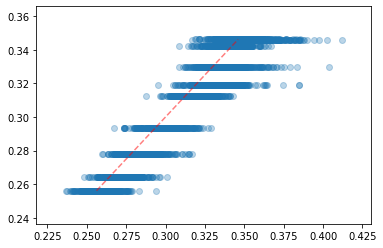

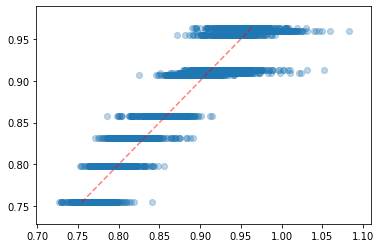

In [289]:
plt.scatter(preds[:,0], truths[:,0], alpha = 0.3)
plt.plot(sorted(truths[:,0]),sorted(truths[:,0]), ls = '--', color = 'r', alpha = 0.5 )
plt.show();
plt.scatter(preds[:,1], truths[:,1], alpha = 0.3)

plt.plot(sorted(truths[:,1]),sorted(truths[:,1]), ls = '--', color = 'r', alpha = 0.5 )
plt.show();

In [290]:
f = h5py.File('../data/UatuLightconeSameSeed.hdf5', 'r')
#for boxno in xrange(5):
boxno = 2
target_boxno = 3
test_X = np.array(f['Box%03d'%boxno]["X"][()])
test_Y = f['Box%03d'%boxno]['Y'][0].reshape((1,2))

target_X = np.array(f['Box%03d'%target_boxno]["X"][()])
target_Y = f['Box%03d'%target_boxno]['Y'][0].reshape((1,2))
f.close()

In [291]:
test_X = (test_X-mean)/(std)
target_X = (target_X-mean)/(std)

In [292]:
n_orig = 100 #201#100 
n_targ = n_orig#201
batch_size = 1 

X = test_X[n_orig, :, :, :].reshape((1, test_X.shape[1],\
                                test_X.shape[2], test_X.shape[3]))
X = np.tile(X, (batch_size, 1, 1, 1) )
Y = test_Y[0, :].reshape((1, test_Y.shape[1]))
Y = np.tile(Y, (batch_size, 1))

In [293]:
np.random.seed(32)
X = np.random.randn(*X.shape)#*X.std() + X.mean()

In [294]:
targ_X = target_X[n_targ, :, :, :].reshape((1, test_X.shape[1],\
                                test_X.shape[2], test_X.shape[3]))

#targ_X = (targ_X-mean)/(std)

In [295]:
from astropy.units import deg

from lenstools import GaussianNoiseGenerator, ConvergenceMap

#Set map side angle, and number of pixels on a side
num_pixel_side = shape[0]
side_angle = 4 * deg

#Read the power spectrum (l,Pl) from an external file, and load it in numpy array format (the generator interpolates the power spectrum between bins)
Pl = image_ps(targ_X.squeeze())

In [296]:
#90% sure this is right
l = np.linspace(128, 128*128, Pl.shape[0]+1)

In [297]:
cmap = ConvergenceMap(gaussian_filter(targ_X.squeeze(), smooth), angle=side_angle)
l2, Pl2 = cmap.powerSpectrum(l)

In [298]:
X = (X- X.mean())/(X.std())*targ_X.std()+targ_X.mean()

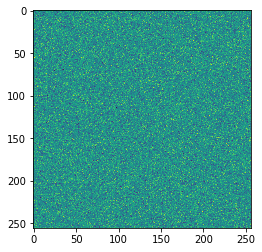

In [299]:
plt.imshow(X.squeeze())

tensor(3.6183, device='cuda:0', grad_fn=<AddBackward0>)
******************** 0 ********************
e 0.0009000000000000001


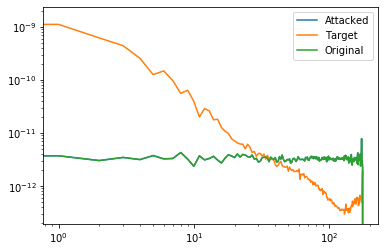

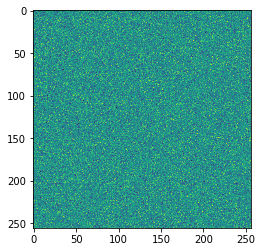

tensor(3.0559, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.5245, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.0712, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7366, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5198, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3266, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1204, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9456, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.8022, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6946, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6189, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5398, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4570, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4316, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4021, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4290, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4465, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4744, device='cuda:0', grad_fn=<AddBack

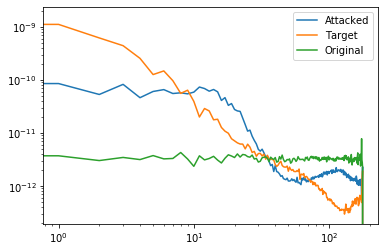

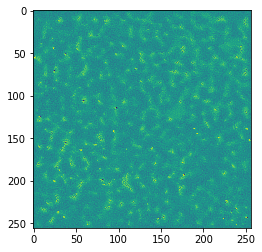

tensor(0.3119, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3306, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3264, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2794, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4092, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3424, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2960, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3320, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4140, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2431, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3304, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2849, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3536, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3439, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3025, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2508, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2745, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3096, device='cuda:0', grad_fn=<AddBack

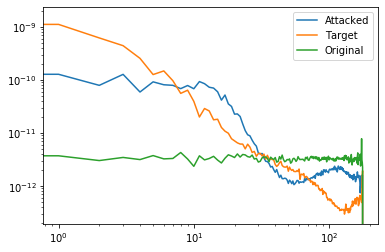

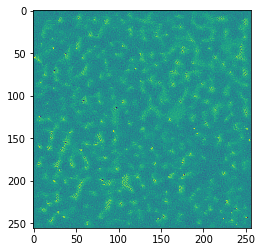

tensor(0.2361, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4403, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4893, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3634, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3881, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3531, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3680, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3689, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3416, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3247, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3148, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3750, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3255, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3431, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2874, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3220, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3847, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3893, device='cuda:0', grad_fn=<AddBack

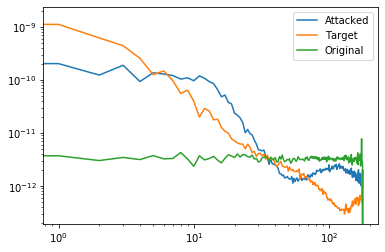

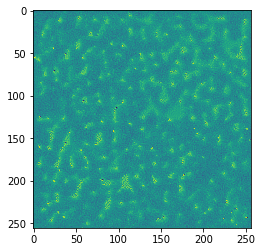

tensor(0.3395, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4220, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4621, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4955, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4476, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4938, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5058, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5252, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5130, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5239, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5108, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5396, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5257, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4936, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5387, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4759, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5230, device='cuda:0', grad_fn=<AddBack

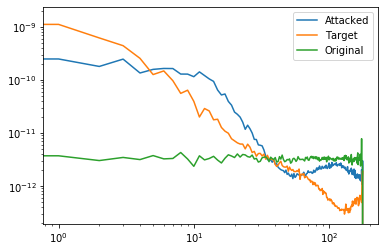

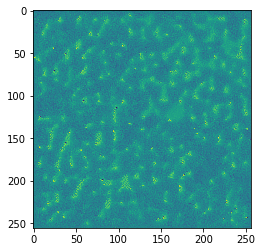

tensor(0.4614, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5689, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5000, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5595, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5017, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5436, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4923, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5444, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4798, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5376, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4773, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5526, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4839, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5365, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4684, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5337, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4723, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5294, device='cuda:0', grad_fn=<AddBack

In [300]:
X_robust, init_embed, robust_embed = compute_robust_map(model,\
                                  torch.Tensor(X).reshape((1, shape[0], shape[1])), \
                                torch.Tensor(gaussian_filter(targ_X,smooth)).reshape((1, shape[0], shape[1])) )#,\

In [301]:
X_robust = X_robust.to('cpu').detach().numpy().squeeze()
init_embed = init_embed.to('cpu').detach().numpy().squeeze()
robust_embed = robust_embed.to('cpu').detach().numpy().squeeze()

In [302]:
init_embed.shape

(128, 2, 2)

In [303]:
def get_embedding_2(x, model):
    x = scattering(x)

    x = x.view(1, model.K, model.input_size, model.input_size)#
############# UNCOMMENT ME ################
    x = model.init_conv(x)

    for i,l in enumerate(model.layers):
        #if i ==1:
        #    break
        x = l(x)
    
    return x

In [304]:
print(np.linalg.norm(init_embed-robust_embed))

0.44452444


In [305]:
X_robust.max(), X.max()

(0.2024823, 0.17691766543333)

In [306]:
vmin = min(X.min(), targ_X.min())
vmax = max(X.max(), targ_X.max())

In [307]:
target_Y

array([[0.350059, 0.946085]])

In [308]:
model(scattering(torch.Tensor(gaussian_filter(targ_X.reshape((1, shape[0], shape[1])), 0)).to('cuda'))).to('cpu').detach().numpy()

array([[0.34632167, 0.9587974 ]], dtype=float32)

In [309]:
model(scattering(torch.Tensor(X_robust.reshape((1, shape[0], shape[1]))).to('cuda'))).to('cpu').detach().numpy()

array([[0.31884545, 0.916134  ]], dtype=float32)

In [310]:
orig_s = scattering(torch.Tensor(X.reshape((1, shape[0], shape[1]))).to('cuda')).to('cpu').detach().numpy()
robust_s = scattering(torch.Tensor(X_robust.reshape((1, shape[0], shape[1]))).to('cuda')).to('cpu').detach().numpy()
targ_s = scattering(torch.Tensor(targ_X.reshape((1, shape[0], shape[1]))).to('cuda')).to('cpu').detach().numpy()

In [311]:
np.linalg.norm(orig_s-targ_s), np.linalg.norm(robust_s-targ_s)

(2.3978426, 2.729745)

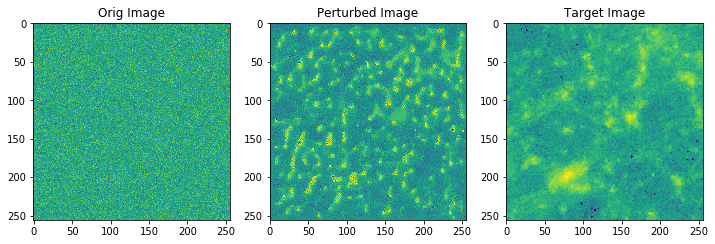

In [312]:
fig = plt.figure(figsize = (12,4))
plt.subplot(131)
plt.title('Orig Image')
plt.imshow(X.squeeze(), vmin = vmin, vmax= vmax)
plt.subplot(132)
plt.title('Perturbed Image')
plt.imshow(X_robust.squeeze(), vmin = vmin, vmax= vmax)
plt.subplot(133)
plt.title('Target Image')
plt.imshow(targ_X.squeeze(), vmin = vmin, vmax= vmax)

(7237,)
(12435,)
(6422,)


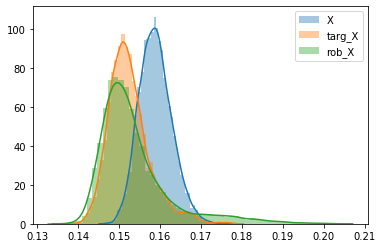

In [313]:
size = 1
orig_peaks = count_peaks(X.squeeze(), size = size)
print(orig_peaks.shape)
sns.distplot(orig_peaks,label = 'X');
targ_peaks = count_peaks(gaussian_filter(targ_X.squeeze(), smooth), size = size)
print(targ_peaks.shape)
sns.distplot(targ_peaks,label = "targ_X")
rob_peaks = count_peaks(X_robust.squeeze(), size = size)
print(rob_peaks.shape)
sns.distplot(rob_peaks,label = 'rob_X')
plt.legend(loc = 'best');

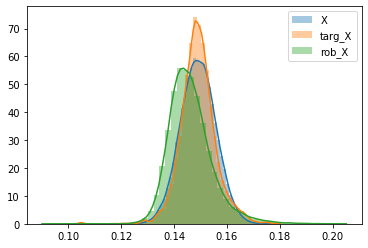

In [314]:
sns.distplot(X.flatten(), label = 'X')
sns.distplot(gaussian_filter(targ_X.flatten(), smooth), label = 'targ_X')
sns.distplot(X_robust.flatten(), label = 'rob_X')
plt.legend(loc='best')

---

In [315]:
attacked_ps = image_ps(X_robust.squeeze())
target_ps = image_ps(gaussian_filter(targ_X.squeeze(), smooth))
normal_ps = image_ps(X.squeeze())
diff_ps = image_ps((X_robust- X.squeeze()).squeeze())

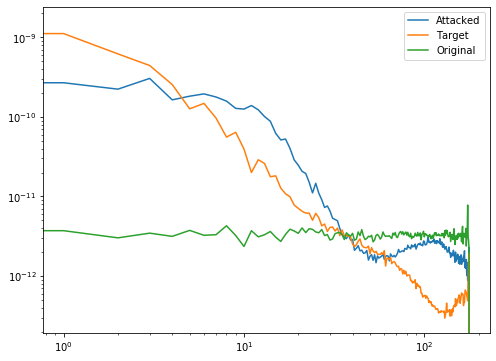

In [316]:
fig = plt.figure(figsize = (8, 6))
#plt.subplot(211)
plt.plot(attacked_ps, label = 'Attacked' )
plt.plot(target_ps, label = 'Target')
plt.plot(normal_ps, label = 'Original')
#plt.plot(diff_ps, label = 'Diff')

plt.legend(loc='best')
plt.loglog();
#plt.subplot(212)
#plt.title("Attacked/Normal")
#plt.plot(attacked_ps/normal_ps, label = 'Attacked')
#plt.plot(target_ps/normal_ps, label = 'Target')
#plt.legend(loc='best')
#plt.ylim([0.4, 6])
#plt.loglog();